### Course: Bayesian Filtering and Smoothing.
### Exercised round: 4
### Student's name: Diego Alejandro Agudelo España.

### Exercise 1. (EKF and SLF)

Consider the following non-linear state space model

\begin{align}
	x_k &= x_{k-1} - 0.01 \sin(x_{k-1}) + q_{k-1},\\
	y_k &= 0.5 \sin(2 x_k) + r_k,
\end{align}


where $q_{k-1}$ has variance $0.01^2$ and $r_k$ has variance $0.02$.



1. Derive the required derivatives for an EKF and implement the EKF for the model. Simulate trajectories from the model, compute the RMSE values and plot the result.
2. For the above model, derive the required expected values for a SLF and implement the SLF for the model. Hint: Use the imaginary part of the inverse Fourier transform of the Gaussian distribution. Compute the RMSE values, plot the results, and compare the performance to the EKF above.

### Solution Exercise 1.

### 1.

The state-space model described above can be rewritten as

$$
\begin{align}
	x_k &= f(x_{k-1}) + q_{k-1},\\
	y_k &= g(x_k) + r_k,
\end{align}
$$

Where

\begin{align}
	f(x) &= x - 0.01 \sin(x) \\
	g(x) &= 0.5 \sin(2x)
\end{align}

In order to use the Extended Kalman Filter it is necessary to take the derivatives of $f(.)$ and $g(.)$

\begin{align}
	f_x(x) &= 1 - 0.01 \cos(x) \\
	g_x(x) &= \cos(2x)
\end{align}

The following is the implementation of the EKF for the described model

In [3]:
%%script octave

%% Generate data

  % Lock random seed
  randn('state',1234);
  
  % rmse function
  rmse = @(AA,BB) sum(sum((AA - BB) .* (AA - BB)));

  % Substitute Simo's 'gauss_rnd', where m is the mean and S the covariance
  gauss_rnd = @(m,S) m + chol(S)'*randn(size(m));
  
  % Define parameters
  steps = 100;  % Number of time steps
  q     = 0.01 * 0.01; % Process noise spectral density
  r     = 0.02;  % Measurement noise variance

  % This is the transition function
  F = @(AA) AA - 0.01 * sin(AA);
  Fx = @(AA) 1. - 0.01 * cos(AA);
  
  % This is the measurement function
  H = @(AA) 0.5 * sin(2 * AA);
  Hx = @(AA) cos(2 * AA);

  % This is the process noise covariance
  Q = q;

  % This is the true initial value
  x0 = 0.0; 

  % Simulate data
  X = zeros(1,steps);  % The true signal
  Y = zeros(1,steps);  % Measurements
  T = 1:steps;         % Time
  x = x0;
  for k=1:steps
    x = gauss_rnd(F(x), Q);
    y = gauss_rnd(H(x), r);
    X(k) = x;
    Y(k) = y;
  end

  % Visualize
  figure; clf;
    plot(T, X,'--',T, Y,'o');
    legend('True signal','Measurements');
    xlabel('Time step'); title('\bf Simulated data')
  saveas(gcf,'R4_SimulatedData.png')
    
  % Report and pause
  fprintf('This is the simulated data. Press enter.\n');
  pause;
  
  %% Extended Kalman filter
  
  % Extended Kalman filter solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST2.

  m2 = 0.0;  % Initialize first step
  P2 = 0.01; % Some uncertanty in covariance  
  EST2 = zeros(1,steps); % Allocate space for results

  % Run Extended Kalman filter
  for k=1:steps
    % Prediction step
    m2 = F(m2);
    P2 = Fx(m2) * P2 * Fx(m2)' + Q;
    % Update step
    vk = Y(k) - H(m2);
    Sk = Hx(m2) * P2 * Hx(m2)' + r;
    Kk = (P2 * Hx(m2)') / Sk;
    m2 = m2 + Kk * vk;
    P2 = P2 - Kk * Sk * Kk';
    % Store the results
    % disp(Kk);
    EST2(k) = m2;
  end

  % Visualize results
  figure; clf
  
  % Plot the signal and its estimate
  subplot(2,1,1);
    plot(T, X,'--', T, EST2,'-',T,Y,'o');
    legend('True signal','Estimated signal','Measurements');
    xlabel('Time step'); title('\bf Kalman filter')
  saveas(gcf,'R4_ExtendedKalmanFilter.png')

  % Compute error
  err2 = rmse(X,EST2)

  % Report and pause
  fprintf('This will be the EKF estimate. Press enter.\n');
  pause;

GNU Octave, version 3.8.2
Copyright (C) 2014 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  For details, type 'warranty'.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at http://www.octave.org.

Please contribute if you find this software useful.
For more information, visit http://www.octave.org/get-involved.html

Read http://www.octave.org/bugs.html to learn how to submit bug reports.
For information about changes from previous versions, type 'news'.

This is the simulated data. Press enter.
err2 =  0.096554
This will be the EKF estimate. Press enter.


Some output formats are not available.


In [1]:
from IPython.display import Image

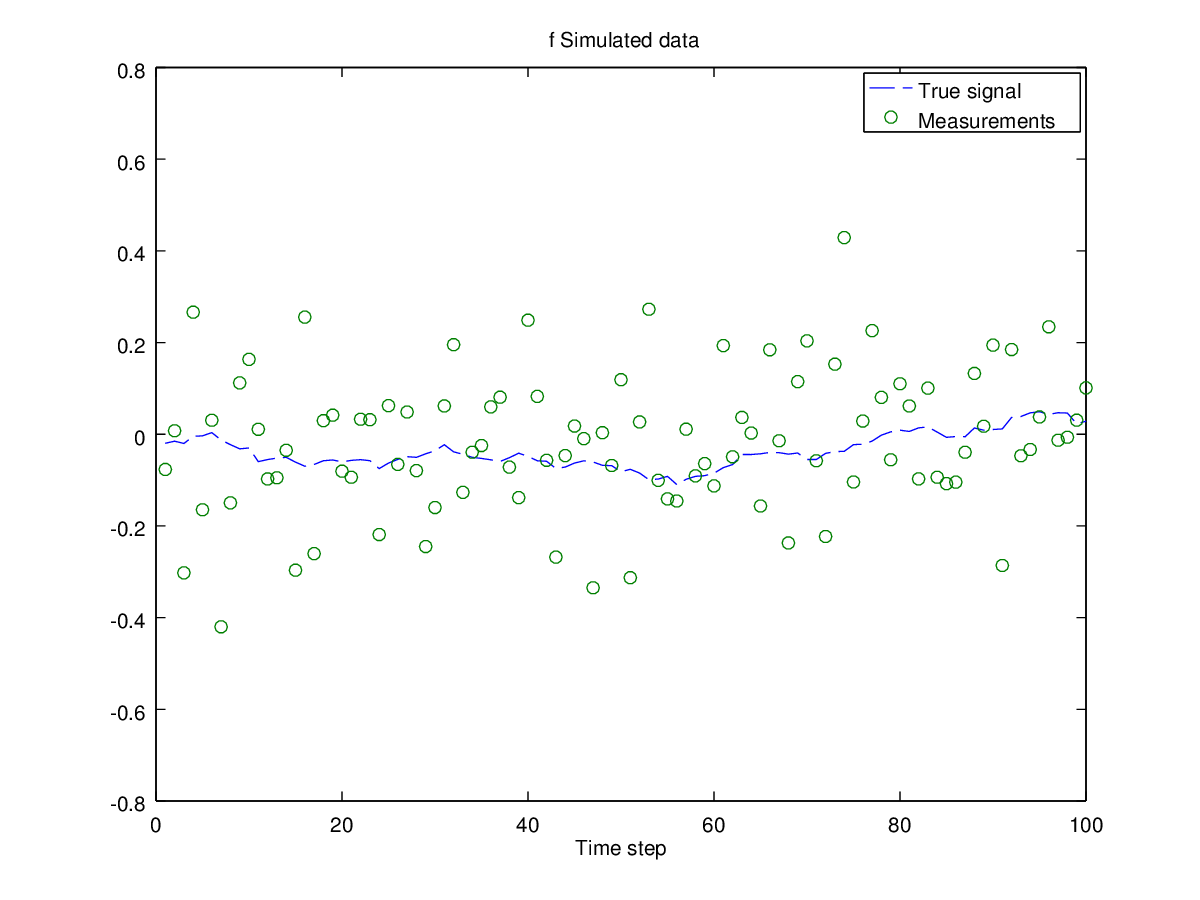

In [3]:
Image(filename='R4_SimulatedData.png', width=600) 

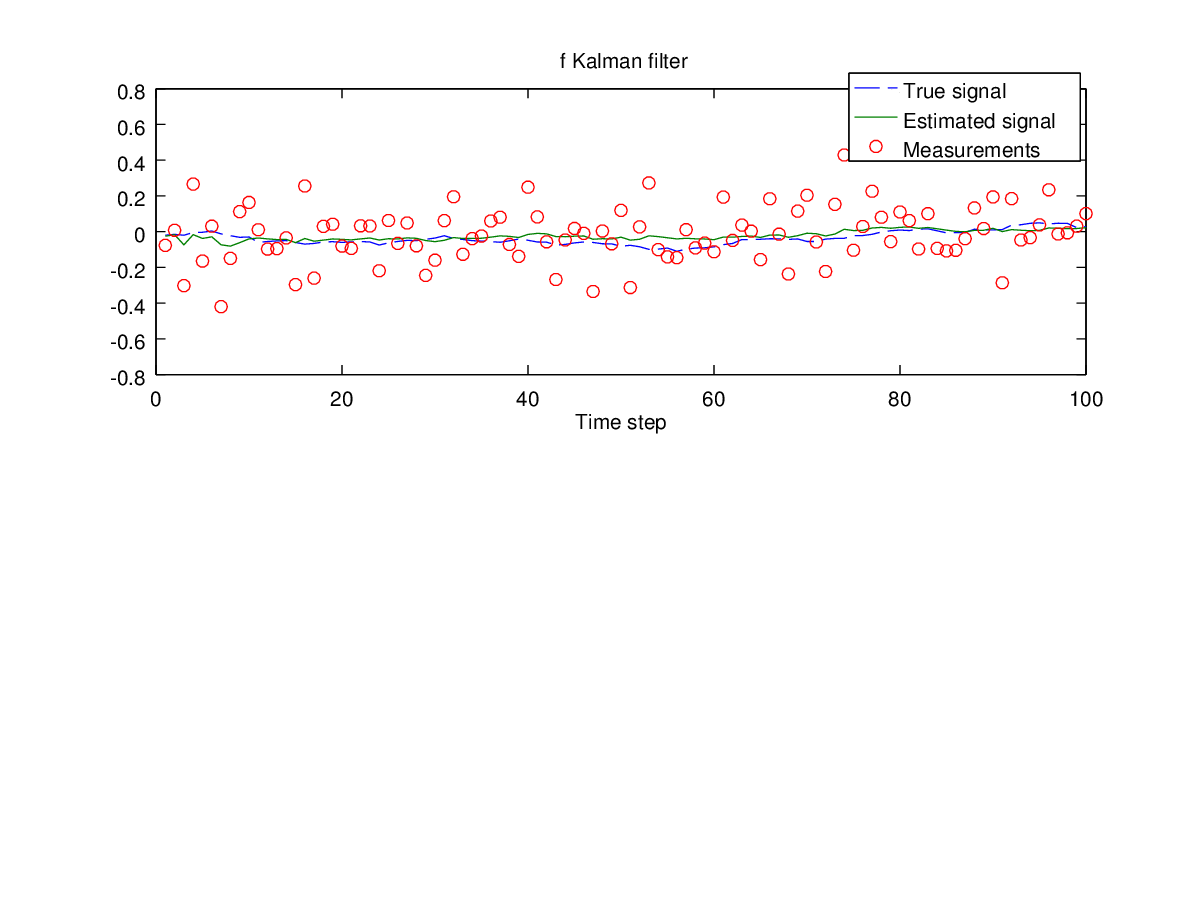

In [4]:
Image(filename='R4_ExtendedKalmanFilter.png', width=600) 

### Exercise 3. (Bearings Only Target Tracking wit EKF)

In this exercise we consider a classical bearings only target tracking problem which frequently arises in the context of passive sensor tracking. In this problem there is a single target in the scene and two angular sensors are used for tracking it. The scenario is illustrated in Figure 1. 

The state of the target at time step $k$ consist of the position $(x_k,y_k)$ and the velocity $(\dot{x}_k, \dot{y}_k)$. The dynamics of the state vector $\mathbf{x}_k = \begin{bmatrix} x_k & y_k & \dot{x}_k & \dot{y}_k \end{bmatrix}^\top$ are modeled with the discretized Wiener velocity model:

\begin{align}
	\begin{bmatrix} x_k \\ y_k \\ \dot{x}_k \\ \dot{y}_k \end{bmatrix} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \dot{x}_{k-1} \\ \dot{y}_{k-1} \end{bmatrix} + \mathbf{q}_{q-1},
\end{align}


where $\mathbf{q}_k$ is a zero mean Gaussian process noise with covariance

\begin{align}
	\mathbf{Q} = \begin{bmatrix} q_1^c \Delta t^3/3 & 0 & q_1^c \Delta t^2/2 & 0 \\ 0 & q_2^c \Delta t^3/3 & 0 & q_2^c \Delta t^2/2 \\ q_1^c \Delta t^2/2 & 0 & q_1^c \Delta t & 0 \\ 0 & q_2^c \Delta t^2/2 & 0 & q_2^c \Delta t \end{bmatrix}.
\end{align}

In this scenario the diffusion coefficients are $q_1^c = q_2^c = 0.1$ and the sampling period is $\Delta t = 0.1$. The measurement model for sensor $i \in \{1, 2\}$ is the following:
\begin{align*}
	\theta_k^i = \tan^{-1} \bigg( \frac{y_k-s_y^i}{x_k-s_x^i} \bigg) + r_k,
\end{align*}
where $(s_x^i,s_y^i)$ is the position of the sensor $i$ and $r_k \sim \mathcal{N}(0, \sigma^2)$ is a Gaussian measurement noise with standard deviation of $\sigma = 0.05$ radians. At each sampling time, which occurs 10 times per second (i.e., $\Delta t = 0.1$), both of the two sensors produce a measurement.

In the file ```angle\_ex.m``` (in Noppa) there is a baseline solution, which computes estimates of the position from the crossing of the measurements and estimates the velocity to be always zero. Your task is to implement an EKF for the problem and compare the results graphically and in RMSE sense.


1. Implement an EKF for the bearings only target tracking problem, which uses the non-linear measurement model (5) as its measurement model function (not the crossings). $\textit{Hints:}$
    * Use the Matlab function $\texttt{atan2}$ in the measurement model instead of $\texttt{atan}$ to directly get an answer in the range $[-\pi, \pi]$.
    * The two measurements at each measurement time can be processed one at a time, that is, you can simply perform two scalar updates instead of a single two dimensional measurement update.
    * Start by computing the Jacobian matrix of the measurement model function with respect to the state components. Before implementing the filter, check by finite differences that the Jacobian matrix is correct.
2. Compute the RMSE values and plot figures of the estimates.

### Solution Exercise 3.

### 1.

In [1]:
%%script octave
%% Bearings only target tracking demo file
%
% Bayesian Estimation of Time-Varying Processes (5 p) L V
%
% This software is distributed under the GNU General Public 
% Licence (version 2 or later); please refer to the file 
% Licence.txt, included with the software, for details.
%
%% Generate data

  % Lock seed
  randn('state',123);

  % Implement RMSE (true and estimate)
  rmse = @(X,EST) sqrt(mean(sum((X-EST).^2)));
  
  % Create a bit curved trajectory and angle
  % measurements from two sensors
  S1 = [-1.5;0.5]; % Position of sensor 1
  S2 = [1;1];      % Position of sensor 2
  sd = 0.05;       % Standard deviation of measurements
  dt = 0.01;       % Sampling period
  x0 = [0;0;1;0];  % Initial state

  a = zeros(1,500);
  a(1,50:100)  = pi/2/51/dt + 0.01*randn(1,51);
  a(1,200:250) = pi/2/51/dt + 0.01*randn(1,51);
  a(1,350:400) = pi/2/51/dt + 0.01*randn(1,51);
  x = x0;
  t = 0;
  X = [];
  Theta = [];
  T = [];
  for i=1:500
    F = [0 0  1    0;...
         0 0  0    1;...
         0 0  0   a(i);...
         0 0 -a(i) 0];
    x = expm(F*dt)*x;
    y1 = atan2(x(2)-S1(2), x(1)-S1(1)) + sd * randn;
    y2 = atan2(x(2)-S2(2), x(1)-S2(1)) + sd * randn;
    t  = t + dt;
    X = [X x];
    T = [T t];
    Theta = [Theta [y1;y2]];
  end
  steps = size(Theta,2);


%% Dynamic model

  % Parameters of the dynamic model
  qc = 0.1;
  
  % This is the transition matrix
  A  = [1 0 dt 0;
        0 1 0 dt;
        0 0 1 0;
        0 0 0 1];

  % This is the process noise covariance
  Q = [qc*dt^3/3 0 qc*dt^2/2 0;
       0 qc*dt^3/3 0 qc*dt^2/2;
       qc*dt^2/2 0 qc*dt 0;
       0 qc*dt^2/2 0 qc*dt];
  
   
%% Baseline solution
   
  % Baseline solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST1.

  %if 0 %% <--- Uncomment to disable
  
  fprintf('Running base line solution.\n');
    
  % Initialize to true value
  m1 = x0;     
  EST1 = zeros(4,steps);
  
  % Set up figure
  figure(1); clf
  
  % Loop through steps
  for k=1:steps
      
    % Compute crossing of the measurements
    dx1 = cos(Theta(1,k));
    dy1 = sin(Theta(1,k));
    dx2 = cos(Theta(2,k));
    dy2 = sin(Theta(2,k));
    d = [dx1 dx2; dy1 dy2]\[S2(1)-S1(1);S2(2)-S1(2)];
    
    % Crossing
    cross_xy = S1 + [dx1;dy1]*d(1);
    
    % Compute estimate
    m1(3:4) = [0;0];
    m1(1:2) = cross_xy;
    EST1(:,k) = m1;
    
    % Animate
    if rem(k,10) == 1
      len = 3;
      dx1 = len*cos(Theta(1,k));
      dy1 = len*sin(Theta(1,k));
      dx2 = len*cos(Theta(2,k));
      dy2 = len*sin(Theta(2,k));
      clf;
      plot(X(1,:),X(2,:),'r-',...
           m1(1),m1(2),'bo',...
           EST1(1,1:k),EST1(2,1:k),'b--',...
           [S1(1);S1(1)+dx1],[S1(2);S1(2)+dy1],'k--',...
           [S2(1);S2(1)+dx2],[S2(2);S2(2)+dy2],'k--');
      axis([-2 2 -2.5 1.5]);
      
      % Pause and draw
      drawnow;
      pause(.1)
    end
  end
    
  % Compute error
  err1 = rmse(X,EST1)

  % Plot baseline
  figure(1); clf

    plot(X(1,:),X(2,:),'--',...
         EST1(1,:),EST1(2,:),'-',...
         S1(1),S1(2),'kx',S2(1),S2(2),'ko')
    legend('True trajectory','Baseline estimate','Sensor 1','Sensor 2');
    xlabel('x'); ylabel('y'); title('\bf Baseline Solution')
    axis([-2 2 -2.5 1.5]);
  
    fprintf('This is the BL solution. Press enter.\n');
    pause;
  
  %end %% <--- Uncomment to disable
 
%% EKF solution
  
  % EKF solution. The estimates
  % of x_k are stored as columns of
  % the matrix EST2.
  
  %if 0 %% <--- Uncomment to disable

  fprintf('Running EKF solution.\n');

  m2 = x0;            % Initialize to true value
  P2 = eye(4);        % Some uncertainty
  R  = sd^2*eye(2);   % The joint covariance
  EST2 = zeros(4,steps);
  
  % Functions and their respective derivatives
 
  % This is the measurement function
  H = @(AA) [atan2(AA(2)-S1(2), AA(1)-S1(1)); atan2(AA(2)-S2(2), AA(1)-S2(1))];
  Hx = @(AA) [(S1(2) - AA(2))/((S1(1) - AA(1))^2 + (S1(2) - AA(2))^2), ...
      -(S1(1) - AA(1))/((S1(1) - AA(1))^2 + (S1(2) - AA(2))^2), 0, 0; ...
    (S2(2) - AA(2))/((S2(1) - AA(1))^2 + (S2(2) - AA(2))^2), ...
    -(S2(1) - AA(1))/((S2(1) - AA(1))^2 + (S2(2) - AA(2))^2), 0, 0];
  
  
  % Set up figure
  figure(1); clf
  
  % Loop through steps
  for k=1:steps
    
    % Compute estimate here
   
    % Prediction step
    m2 = A * m2;
    P2 = A * P2 * A' + Q;
    % Update step
    vk = Theta(:, k) - H(m2);
    Sk = Hx(m2) * P2 * Hx(m2)' + R;
    Kk = (P2 * Hx(m2)') / Sk;
    m2 = m2 + Kk * vk;
    P2 = P2 - Kk * Sk * Kk';
    EST2(:,k) = m2;
    
    % Animate
    if rem(k,10) == 1
      len = 3;
      dx1 = len*cos(Theta(1,k));
      dy1 = len*sin(Theta(1,k));
      dx2 = len*cos(Theta(2,k));
      dy2 = len*sin(Theta(2,k));
      clf;
      plot(X(1,:),X(2,:),'r-',...
           m2(1),m2(2),'bo',...
           EST2(1,1:k),EST2(2,1:k),'b--',...
           [S1(1);S1(1)+dx1],[S1(2);S1(2)+dy1],'k--',...
           [S2(1);S2(1)+dx2],[S2(2);S2(2)+dy2],'k--');
      axis([-2 2 -2.5 1.5]);
      
      % Pause and draw
      drawnow;
      pause(.1)
    end
  end

  % Compute error
  err2 = rmse(X,EST2)
  
  % Plot EKF
  figure(1); clf

    plot(X(1,:),X(2,:),'--',...
         EST2(1,:),EST2(2,:),'-',...
         S1(1),S1(2),'kx',S2(1),S2(2),'ko')
    legend('True trajectory','EKF estimate','Sensor 1','Sensor 2');
    xlabel('x'); ylabel('y'); title('\bf EKF Solution')
    axis([-2 2 -2.5 1.5]);
  
  
  fprintf('This will be the EKF solution. Press enter.\n');
  pause;
  
  %end %% <--- Uncomment to disable

GNU Octave, version 3.8.2
Copyright (C) 2014 John W. Eaton and others.
This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE.  For details, type 'warranty'.

Octave was configured for "x86_64-pc-linux-gnu".

Additional information about Octave is available at http://www.octave.org.

Please contribute if you find this software useful.
For more information, visit http://www.octave.org/get-involved.html

Read http://www.octave.org/bugs.html to learn how to submit bug reports.
For information about changes from previous versions, type 'news'.

Running base line solution.
err1 =  1.0194
This is the BL solution. Press enter.
Running EKF solution.
err2 =  0.42732
This will be the EKF solution. Press enter.


### 2.

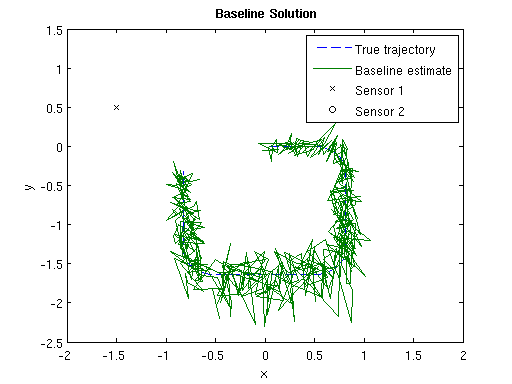

In [8]:
Image(filename='R4_Baseline_Bearings.png', width=400) 

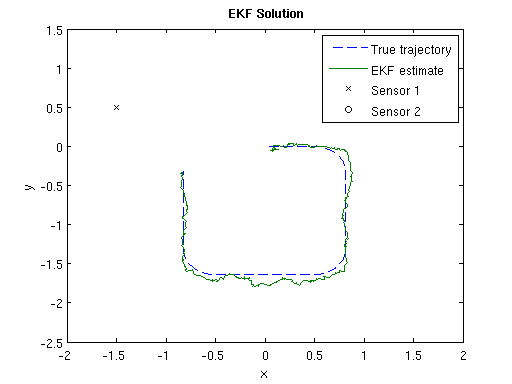

In [7]:
Image(filename='R4_EKF_Bearings.png', width=400) 

Method | RMSE
--- | --- 
Baseline Solution | 1.0194
EKF Solution | 0.42732